In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [249]:
def exists(val):
    return val is not None

class PeriodicLayer(nn.Module): # periodic layer
    def __init__(self, dim_in, dim_out, use_bias = True):
        super().__init__()
        self.dim_in = dim_in
        weight = torch.zeros(dim_out, dim_in)
        w1 = torch.zeros(3, dim_out)
        bias = torch.zeros(2, dim_out) if use_bias else None
        
        self.init_(weight, bias, w1)
        self.weight = nn.Parameter(weight)
        self.w1 = nn.Parameter(w1)
        self.bias = nn.Parameter(bias) if use_bias else None

    def init_(self, weight, bias, w1):
        dim = self.dim_in
        w_std = (1 / dim)
        weight.uniform_(-w_std, w_std)
        w1.uniform_(-w_std, w_std)

        if exists(bias):
            bias.uniform_(-w_std, w_std)

    def forward(self, x):
        a = self.bias[0]
        b = self.bias[1]
        # x = w*(sin((2 Pi x) + a) + b)
        x =  torch.mm(x, self.weight.t())
        x = x * 2 * math.pi
        x = torch.add(x, a)
        x = torch.sin(x)
        x = torch.add(x, b)
        return x

In [43]:
class Pinn(nn.Module):
    def __init__(self):
        super(Pinn, self).__init__()
        self.loss_function = nn.MSELoss()
        self.layer_size = 50
        # self.PL_size = 64
        # self.space_dense = nn.Linear(1, self.PL_size) # input: [x]
        # self.time_dense = nn.Linear(1, self.PL_size) # input: [t]
        # self.periodic_layer = PeriodicLayer(dim_in=self.PL_size, dim_out=self.PL_size)
        self.dense_layers = nn.Sequential(
            nn.Linear(2, self.layer_size), # input: [x, t]
            nn.Sigmoid(),
            nn.Linear(self.layer_size, self.layer_size),
            nn.Sigmoid(),
            nn.Linear(self.layer_size, self.layer_size),
            nn.Sigmoid(),
            nn.Linear(self.layer_size, self.layer_size),
            nn.Sigmoid(),
            nn.Linear(self.layer_size, self.layer_size),
            nn.Sigmoid(),
            nn.Linear(self.layer_size, 8) # output: [rho, vx, vy, vz, Bx, By, Bz, P]
        )

    def forward(self, input):
        # x = input[:,[0]]
        # t = input[:,[1]]
        # x = self.space_dense(x)
        # t = self.time_dense(t)
        # x_per = self.periodic_layer(x)
        # input = torch.cat((x_per, t),axis=1)
        out = self.dense_layers(input)
        return out

    def PDELoss(self, input):
        g = input.clone()
        out = self.forward(g)
        rho = out[:,[0]]
        vx  = out[:,[1]]
        vy  = out[:,[2]]
        vz  = out[:,[3]]
        Bx  = out[:,[4]]
        By  = out[:,[5]]
        Bz  = out[:,[6]]
        P   = out[:,[7]]

        rho_r = torch.autograd.grad(rho,g,torch.ones([input.shape[0], 1]).to(device), create_graph=True)[0]
        vx_r  = torch.autograd.grad(vx ,g,torch.ones([input.shape[0], 1]).to(device), create_graph=True)[0]
        vy_r  = torch.autograd.grad(vy ,g,torch.ones([input.shape[0], 1]).to(device), create_graph=True)[0]
        vz_r  = torch.autograd.grad(vz ,g,torch.ones([input.shape[0], 1]).to(device), create_graph=True)[0]
        Bx_r  = torch.autograd.grad(Bx ,g,torch.ones([input.shape[0], 1]).to(device), create_graph=True)[0]
        By_r  = torch.autograd.grad(By ,g,torch.ones([input.shape[0], 1]).to(device), create_graph=True)[0]
        Bz_r  = torch.autograd.grad(Bz ,g,torch.ones([input.shape[0], 1]).to(device), create_graph=True)[0]
        P_r   = torch.autograd.grad(P  ,g,torch.ones([input.shape[0], 1]).to(device), create_graph=True)[0]

        rho_x = rho_r[:,[0]]
        rho_t = rho_r[:,[1]]

        vx_x = vx_r[:,[0]]
        vx_t = vx_r[:,[1]]

        vy_x = vy_r[:,[0]]
        vy_t = vy_r[:,[1]]

        vz_x = vz_r[:,[0]]
        vz_t = vz_r[:,[1]]

        Bx_x = Bx_r[:,[0]]
        Bx_t = Bx_r[:,[1]]

        By_x = By_r[:,[0]]
        By_t = By_r[:,[1]]

        Bz_x = Bz_r[:,[0]]
        Bz_t = Bz_r[:,[1]]

        P_x = P_r[:,[0]]
        P_t = P_r[:,[1]]

        u_0 = 1.0
        a = 1.0/u_0

        # MHD equations in 1D ( d/dy = d/dz = 0 )
        eq1 = rho_t + rho*(vx_x) + vx*rho_x
        # Energy
        eq2 = P*(-2.0)*(rho**(-3.0))*rho_t + (rho**(-2.0))*P_t
        # Euler equations of motion
        eq3 = rho*vx_t + P_x + a*By*(By_x) + a*Bz*(Bz_x)
        eq4 = rho*vy_t - a*Bx*(By_x)
        eq5 = rho*vz_t - a*Bx*(Bz_x)
        # Induction equations
        eq7 = By_t - vy*(Bx_x) + By*(vx_x) - Bx*vy_x + vx*By_x
        eq8 = Bz_t - vz*(Bx_x) + Bz*(vx_x) - Bx*vz_x + vx*Bz_x
        # Magnetic field divergence
        eq9 = Bx_x

        loss1 = self.loss_function(eq1, torch.zeros_like(eq1))
        loss2 = self.loss_function(eq2, torch.zeros_like(eq2))
        loss3 = self.loss_function(eq3, torch.zeros_like(eq3))
        loss4 = self.loss_function(eq4, torch.zeros_like(eq4))
        loss5 = self.loss_function(eq5, torch.zeros_like(eq5))
        loss6 = self.loss_function(Bx , torch.ones_like(Bx)*0.75)
        loss7 = self.loss_function(eq7, torch.zeros_like(eq7))
        loss8 = self.loss_function(eq8, torch.zeros_like(eq8))
        loss9 = self.loss_function(eq9, torch.zeros_like(eq9))

        return (loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7 + loss8 + loss9)


    def BCLoss(self, input_bc, output_bc):
        out = self.forward(input_bc)
        # rho = out[:,[0]]
        # vx = out[:,[1]]
        # vy = out[:,[2]]
        # vz = out[:,[3]]
        # Bx = out[:,[4]]
        # By = out[:,[5]]
        # Bz = out[:,[6]]
        # P = out[:,[7]]
        loss1 = self.loss_function(out[:,[0]], output_bc[:,[0]])
        loss2 = self.loss_function(out[:,[1]], output_bc[:,[1]])
        loss3 = self.loss_function(out[:,[2]], output_bc[:,[2]])
        loss4 = self.loss_function(out[:,[3]], output_bc[:,[3]])
        loss5 = self.loss_function(out[:,[4]], output_bc[:,[4]])
        loss6 = self.loss_function(out[:,[5]], output_bc[:,[5]])
        loss7 = self.loss_function(out[:,[6]], output_bc[:,[6]])
        loss8 = self.loss_function(out[:,[7]], output_bc[:,[7]])

        return (loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7 + loss8)
        return loss1

    def loss(self, input_pde, input_bc, output_bc):
        loss_u = self.PDELoss(input_pde)
        loss_f = self.BCLoss(input_bc, output_bc)
        return (loss_f + loss_u)
        

In [44]:
net = Pinn()
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters())
lowest_loss = 99999999.0

x = torch.ones(5)*0.1
y = torch.ones(5)*0.2
t = torch.ones(5)*0.1
input = torch.stack((x,t), dim=1)
# print(input)
output = net.forward(input)
print(net)

Pinn(
  (loss_function): MSELoss()
  (dense_layers): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=50, out_features=8, bias=True)
  )
)


In [ ]:
m0 = 0.0
m1 = 1.0
x_min, y_min, z_min = m0, m0, m0
x_max, y_max, z_max = m1, m1, m1
t_min = 0.0
t_max = 0.2
Pi = np.pi
mid = (m1 + m0)/2.0

# Initial conditions for Brio Wu Shock Tube

# Mass density at t=0
def rho_t0(x):
    rho = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] < mid:
            rho[i] = 1.0
        else:
            rho[i] = 0.125
    return rho

# Velocity field at t=0
def v_t0(x):
    vx = np.zeros_like(x)
    vy = np.zeros_like(x)
    vz = np.zeros_like(x)
    return vx, vy, vz

# Magnetic field at t=0
def B_t0(x):
    Bx = np.ones_like(x)*0.75
    By = np.zeros_like(x)
    Bz = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] < mid:
            By[i] = 1.0
        else:
            By[i] = -1.0
    return Bx, By, Bz

# Pressure at t=0
def P_t0(x):
    P = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] < mid:
            P[i] = 1.0
        else:
            P[i] = 0.1
    return P

## Boundary conditions given at t=0
def boundary_conditions(x):
    rho = rho_t0(x)
    vx, vy, vz = v_t0(x)
    Bx, By, Bz = B_t0(x)
    P = P_t0(x)
    return rho, vx, vy, vz, Bx, By, Bz, P

# x_bc = np.arange(x_min, x_max, (x_max-x_min)/500.0)
# y_bc = np.arange(y_min, y_max, (y_max-y_min)/500.0)
# z_bc = np.arange(z_min, z_max, (z_max-z_min)/500.0)
# rho, vx, vy, vz, Bx, By, Bz, P = boundary_conditions(x_bc)
# plt.plot(rho)

In [68]:
# Training / Fitting ------ 3D
iterations = 40000
previous_validation_loss = 99999999.0
lowest_loss = 99999999.0
batch_size = 500

for epoch in range(iterations):
    
    optimizer.zero_grad()

    # BC at t=0
    x_bc = np.random.uniform(low=x_min, high=x_max, size=(batch_size,1))
    t_bc = np.zeros((batch_size,1))
    input_bc = np.concatenate((x_bc, t_bc), axis=1)
    pt_input_bc = Variable(torch.from_numpy(input_bc).float(), requires_grad=False).to(device)
    rho, vx, vy, vz, Bx, By, Bz, P = boundary_conditions(x_bc)
    output_bc = np.concatenate((rho, vx, vy, vz, Bx, By, Bz, P), axis=1)
    pt_output_bc = Variable(torch.from_numpy(output_bc).float(), requires_grad=False).to(device)
    bc_loss = net.BCLoss(pt_input_bc, pt_output_bc)

    # BC at x=0,1
    x_bc = np.zeros((batch_size,1))
    x_bc[:(int(batch_size/2)),] = 1.0
    t_bc = np.random.uniform(low=t_min, high=t_max, size=(batch_size,1))
    input_bc = np.concatenate((x_bc, t_bc), axis=1)
    pt_input_bc = Variable(torch.from_numpy(input_bc).float(), requires_grad=False).to(device)
    rho, vx, vy, vz, Bx, By, Bz, P = boundary_conditions(x_bc)
    output_bc = np.concatenate((rho, vx, vy, vz, Bx, By, Bz, P), axis=1)
    pt_output_bc = Variable(torch.from_numpy(output_bc).float(), requires_grad=False).to(device)
    bc_loss += net.BCLoss(pt_input_bc, pt_output_bc)
    
    # PDE Loss
    x_collocation = np.random.uniform(low=x_min, high=x_max, size=(batch_size,1))
    t_collocation = np.random.uniform(low=t_min, high=t_max, size=(batch_size,1))
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    input_pde = torch.cat([pt_x_collocation, pt_t_collocation], dim=1)
    
    if iterations>20000:
        pde_loss = net.PDELoss(input_pde)
        loss = 10*bc_loss + pde_loss
    else:
        loss = bc_loss
    
    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
        if(loss.data < lowest_loss):
            lowest_loss = loss.data
            torch.save(net.state_dict(), 'shocktube_model.pt')
            if(epoch % 10 == 0):
                print(epoch,"Training Loss:",loss.data)
        if(epoch % 100 == 0):
            print(epoch,"Training Loss:",loss.data)

0 Training Loss: tensor(0.4988)
0 Training Loss: tensor(0.4988)
100 Training Loss: tensor(0.5272)
200 Training Loss: tensor(0.5478)
300 Training Loss: tensor(0.5477)
400 Training Loss: tensor(0.3370)
500 Training Loss: tensor(0.4153)
600 Training Loss: tensor(0.5217)
700 Training Loss: tensor(0.3836)
800 Training Loss: tensor(0.4849)
900 Training Loss: tensor(0.5566)
1000 Training Loss: tensor(0.5240)
1100 Training Loss: tensor(0.3928)
1200 Training Loss: tensor(0.3915)
1300 Training Loss: tensor(0.5640)
1400 Training Loss: tensor(0.4415)
1500 Training Loss: tensor(0.2617)
1600 Training Loss: tensor(0.5680)
1700 Training Loss: tensor(0.3831)
1800 Training Loss: tensor(0.3562)
1900 Training Loss: tensor(0.6321)
2000 Training Loss: tensor(0.4422)
2100 Training Loss: tensor(0.4444)
2200 Training Loss: tensor(0.3669)
2300 Training Loss: tensor(0.4496)
2400 Training Loss: tensor(0.4094)
2500 Training Loss: tensor(0.3407)
2600 Training Loss: tensor(0.3691)
2700 Training Loss: tensor(0.5517)


/var/folders/3p/xd5lk7j174n62l9vrjj7hwv40000gn/T/ipykernel_19812/3387792084.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x1, t1, rho_mat, cmap='jet')


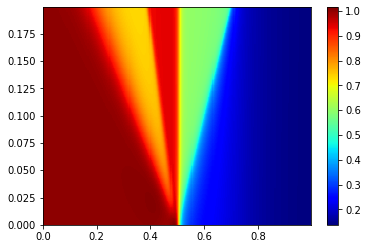

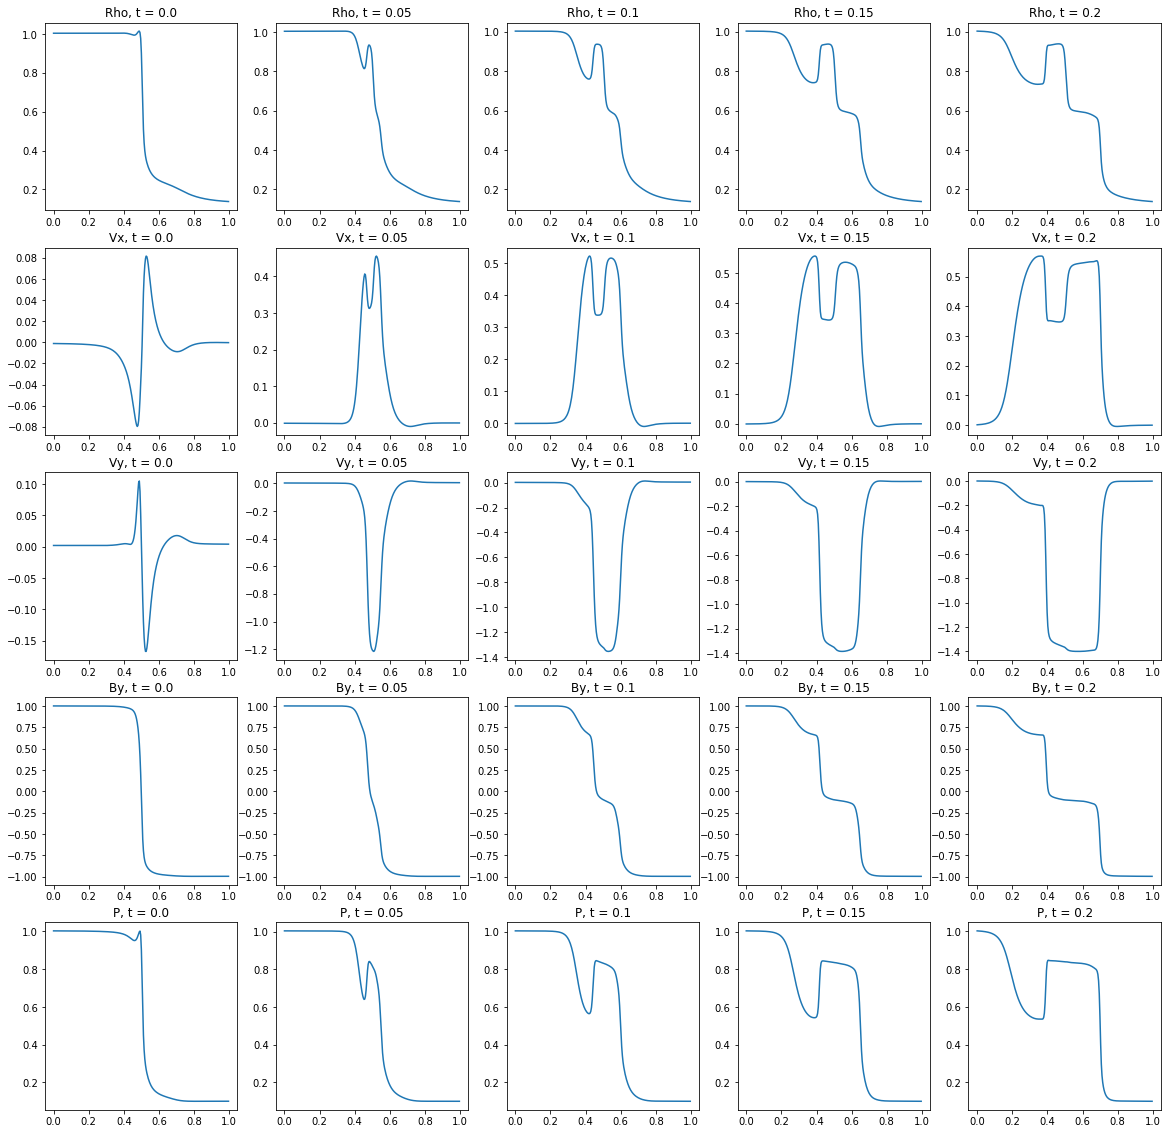

In [82]:
# Graphing

net.load_state_dict(torch.load('shocktube_model.pt'))
# torch.save(net.state_dict(), 'shocktube_model_benchmark.pt')

net.eval()

N = 256
dx = (x_max - x_min) / N
dt = (t_max - t_min) / N 
rho_mat = np.zeros((N,N))

# Plot BC
x1 = np.arange(x_min, x_max, dx)
t1 = np.arange(t_min, t_max, dt)
t2 = (t1 - t_min)/dt
x = np.reshape(x1, (N,1))
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=False).to(device)
for j in range(len(t1)):
    i = t1[j]
    t = np.ones((N,1))*i
    pt_t = Variable(torch.from_numpy(t).float(), requires_grad=False).to(device)
    input = torch.cat([pt_x, pt_t],axis=1)
    pt_rho = net.forward(input)[:,[0]]
    rho = pt_rho.data.cpu().numpy()
    rho_mat[j,:] = np.reshape(rho, (N,))
    # print(i,int(j))
plt.pcolor(x1, t1, rho_mat, cmap='jet')
plt.colorbar()
plt.show()

fig, axs = plt.subplots(5, 5, figsize=(20,20))
p=0
for t_val in [0.0, 0.05, 0.1, 0.15, 0.2]:
# for t_val in [0.0]:
    t = np.ones((N,1))*t_val
    pt_t = Variable(torch.from_numpy(t).float(), requires_grad=False).to(device)
    input = torch.cat([pt_x, pt_t],axis=1)
    out = net.forward(input)
    pt_rho = out[:,[0]]
    pt_vx = out[:,[1]]
    pt_vy = out[:,[2]]
    pt_By = out[:,[5]]
    pt_P = out[:,[7]]
    rho = pt_rho.data.cpu().numpy()
    vx = pt_vx.data.cpu().numpy()
    vy = pt_vy.data.cpu().numpy()
    By = pt_By.data.cpu().numpy()
    P = pt_P.data.cpu().numpy()
    ax = axs[0,p]
    ax.plot(x1,rho)
    ax.title.set_text('Rho, t = ' + str(t_val))
    ax = axs[1,p]
    ax.plot(x1,vx)
    ax.title.set_text('Vx, t = ' + str(t_val))
    ax = axs[2,p]
    ax.plot(x1,vy)
    ax.title.set_text('Vy, t = ' + str(t_val))
    ax = axs[3,p]
    ax.plot(x1,By)
    ax.title.set_text('By, t = ' + str(t_val))
    ax = axs[4,p]
    ax.plot(x1,P)
    ax.title.set_text('P, t = ' + str(t_val))
    p+=1
